# Forest Cover Type Prediction

My attempt at the [Forest Cover Type Prediction Kaggle Competition](https://www.kaggle.com/c/forest-cover-type-prediction), one of the [recommended starter projects](https://www.quora.com/What-Kaggle-competitions-should-a-beginner-start-with-1) I'm working through as part of my [ML Study Curriculum](http://karlrosaen.com/ml). Many thanks to the excellent [Python Machine Learning Book](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka/dp/1783555130) ([and notebooks](https://github.com/rasbt/python-machine-learning-book))—this notebook is largely an excercise in applying the technique's I've learned in working through it.

## Loading and preprocessing 

Let's load the labeled test dataset into a Pandas Dataframe and take a gander. The [dataset section](https://www.kaggle.com/c/forest-cover-type-prediction/data) of the competition also summarizes the variables in the dataset.

In [1]:
import pandas as pd

labeled_df = pd.read_csv('train.csv')

In [2]:
labeled_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
print("Variables with missing rows:")
labeled_df.isnull().sum()

Variables with missing rows:


Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


It looks like our job is easier than with the titanic competition: the categorical variables are already one-hot encoded, and there are no missing values. 

We still need to take care of:
- standard scaling of quantitative features
- pushing categorical variables from {0,1} to {-1, 1}

In [4]:
# %load preprocess.py
from sklearn.preprocessing import StandardScaler
import functools
import operator


def make_preprocessor(td, column_summary):
    # it's important to scale consistently on all preprocessing based on
    # consistent scaling, so we do it once and keep ahold of it for all future
    # scaling.
    stdsc = StandardScaler()
    stdsc.fit(td[column_summary['quantitative']])

    def scale_q(df, column_summary):
        df[column_summary['quantitative']] = stdsc.transform(df[column_summary['quantitative']])
        return df, column_summary

    def scale_binary_c(df, column_summary):
        binary_cs = [['{}{}'.format(c, v) for v in vs] for c, vs in column_summary['categorical'].items()]
        all_binary_cs = functools.reduce(operator.add, binary_cs)
        df[all_binary_cs] = df[all_binary_cs].applymap(lambda x: 1 if x == 1 else -1)
        return df, column_summary

    def preprocess(df):
        fns = [scale_q, scale_binary_c]

        cs = column_summary
        for fn in fns:
            df, cs = fn(df, cs)

        return df

    return preprocess, column_summary


## Exploring

We can scale and explore our dataset. 

### PCA 

It's interesting to look at the eigenvalues of the covariance matrix available via PCA even if we do not reduce the dimensions for our training.

In [5]:
preprocess, column_summary = make_preprocessor(
    labeled_df,
    {
        'quantitative': ['Elevation', 'Aspect', 'Slope', 
              'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
              'Horizontal_Distance_To_Roadways', 
              'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
              'Horizontal_Distance_To_Fire_Points'],
        'categorical': {
            'Wilderness_Area': [1, 2, 3, 4],
            'Soil_Type': list(range(1, 41))
        },
        'ordinal': {
            
        }
    }
)

/Users/krosaen/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [6]:
labeled_df_wrangled = preprocess(labeled_df)

labeled_df_wrangled.head()

/Users/krosaen/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,-0.367095,-0.959980,-1.597132,0.146639,-0.834074,-0.908681,0.271454,0.571653,0.281259,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
1,2,-0.381461,-0.914559,-1.715424,-0.072337,-0.932054,-0.999246,0.238732,0.703225,0.346627,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
2,3,0.130912,-0.160577,-0.887379,0.194243,0.227369,1.106379,0.696843,0.834797,-0.002005,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
3,4,0.085421,-0.015231,0.177250,0.070474,1.092853,1.038455,0.827731,0.834797,-0.285268,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
4,5,-0.369489,-1.014485,-1.715424,-0.353198,-0.850404,-0.998491,0.238732,0.659368,0.324838,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5


In [7]:
def extract_X_y(df):
    return df.iloc[:, 1:-1].values, df.iloc[:, -1].values

X, y = extract_X_y(labeled_df_wrangled)

In [10]:
import numpy as np
from sklearn.decomposition import PCA

pca_explore = PCA()
X_train_pca = pca_explore.fit_transform(X)
pca_explore.explained_variance_ratio_

for i, cum_var in enumerate(np.cumsum(pca_explore.explained_variance_ratio_)):
    print("with {}/{} dimensions we preserve {:.2f} of variance".format(i + 1, X.shape[1] + 1, cum_var))
    if cum_var >= .95:
        break

with 1/55 dimensions we preserve 0.21 of variance
with 2/55 dimensions we preserve 0.37 of variance
with 3/55 dimensions we preserve 0.49 of variance
with 4/55 dimensions we preserve 0.58 of variance
with 5/55 dimensions we preserve 0.65 of variance
with 6/55 dimensions we preserve 0.69 of variance
with 7/55 dimensions we preserve 0.72 of variance
with 8/55 dimensions we preserve 0.75 of variance
with 9/55 dimensions we preserve 0.78 of variance
with 10/55 dimensions we preserve 0.80 of variance
with 11/55 dimensions we preserve 0.81 of variance
with 12/55 dimensions we preserve 0.83 of variance
with 13/55 dimensions we preserve 0.84 of variance
with 14/55 dimensions we preserve 0.86 of variance
with 15/55 dimensions we preserve 0.87 of variance
with 16/55 dimensions we preserve 0.88 of variance
with 17/55 dimensions we preserve 0.89 of variance
with 18/55 dimensions we preserve 0.90 of variance
with 19/55 dimensions we preserve 0.91 of variance
with 20/55 dimensions we preserve 0.92 o

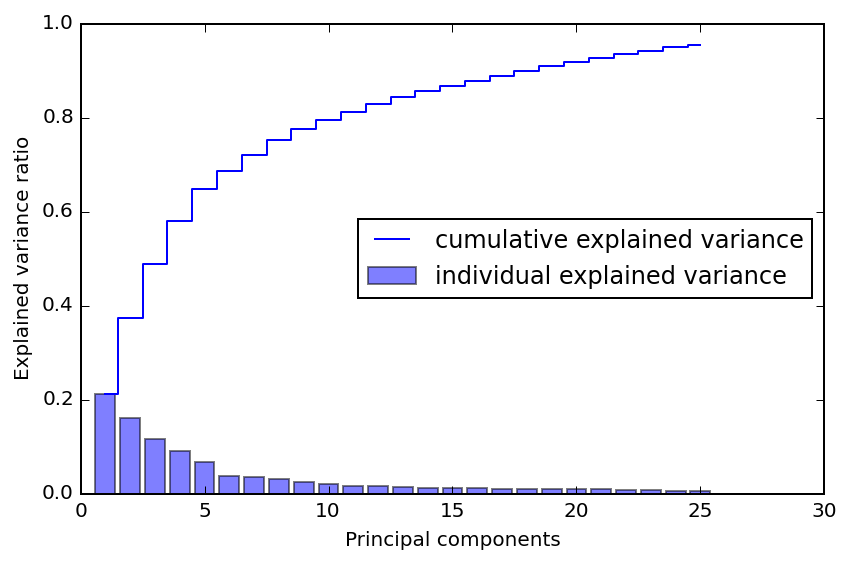

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.bar(
    range(1, 26), 
    pca_explore.explained_variance_ratio_[:25], 
    alpha=0.5, align='center',
    label='individual explained variance')
plt.step(
    range(1, 26), 
    np.cumsum(pca_explore.explained_variance_ratio_[:25]), 
    where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

## Evaluating / submitting using off the shelf algs

Let's compare performance of a few off the shelf models. We split the labaled data into a 70/30 training/test split so we can not only see how well it can fit data, but how well it generalizes to an unseen portion.

For each model, let's also try it on a PCA reduced dataset; we showed we can retain 95% of the variance of our dataset with the first 24 features, will be intersting to see if we retain performance in our model and save on train / fit time.

### Train / Test Split

In [12]:
from sklearn.cross_validation import train_test_split

labeled_df_train, labeled_df_test = train_test_split(labeled_df, test_size=0.3, random_state=0)
labeled_df_train, labeled_df_test = labeled_df_train.copy(), labeled_df_test.copy()

(labeled_df_train.shape, labeled_df_test.shape)

((10584, 56), (4536, 56))

We need a preprocess function that is fit to just the training set so that when we evaluate the model performance on the unseen test split, the test split data can be fit with the same parameters.

In [13]:
preprocess_for_model_evaluation, _ = make_preprocessor(
    labeled_df_train,
    {
        'quantitative': ['Elevation', 'Aspect', 'Slope', 
              'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
              'Horizontal_Distance_To_Roadways', 
              'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
              'Horizontal_Distance_To_Fire_Points'],
        'categorical': {
            'Wilderness_Area': [1, 2, 3, 4],
            'Soil_Type': list(range(1, 41))
        },
        'ordinal': {
            
        }
    }
)

labeled_df_train_wrangled = preprocess_for_model_evaluation(labeled_df_train)
labeled_df_test_wrangled = preprocess_for_model_evaluation(labeled_df_test)

labeled_df_train_wrangled.head()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
2902,2903,0.443033,1.089822,-0.771255,-1.080497,-0.837000,0.090223,-0.630140,1.009898,1.145001,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
10499,10500,1.792946,0.989782,-0.533998,0.584584,-0.033990,-0.209066,-0.762352,1.141218,1.298067,...,-1,-1,-1,-1,-1,-1,-1,-1,1,7
14973,14974,-0.616240,-0.501711,-0.296740,-0.938182,-0.837000,-0.485624,0.989457,0.046887,-0.691794,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
14364,14365,1.807358,-0.056082,-0.415369,0.484964,0.719856,1.676076,0.758086,0.878579,-0.079529,...,-1,-1,-1,-1,-1,-1,-1,-1,1,7
1421,1422,0.784114,-1.111040,-0.771255,-0.444825,-0.935328,0.387996,0.196185,-0.040659,-0.013929,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### X, y and train / test

In [14]:
from sklearn.cross_validation import train_test_split

X_train, y_train = extract_X_y(labeled_df_train_wrangled)
X_test, y_test = extract_X_y(labeled_df_test_wrangled)

pca_evaluate = PCA(n_components=24)
pca_evaluate.fit(X_train)
X_train_pca = pca_evaluate.transform(X_train)
X_test_pca = pca_evaluate.transform(X_test)

(X_train.shape, X_test.shape)

((10584, 54), (4536, 54))

### Choosing some models to evaluate

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def labeled_models():
    return [
        ("logistic_regression", LogisticRegression(C=100.0, random_state=0)),
        ("decision_tree6", DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)),
        ("random_forest10", RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)),
        ("linear_svm", SVC(kernel='linear', C=1.0, random_state=0)),
        ("kernel_svm", SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0))    
    ]

### Evaluating test/train performance

In [16]:
from sklearn.metrics import accuracy_score
import time

for label, model in labeled_models():
    for pca in [False, True]:
        if pca:
            X_train_eval = X_train_pca
            X_test_eval = X_test_pca
        else:
            X_train_eval = X_train
            X_test_eval = X_test
            
        pre_fit = time.clock()
        model.fit(X_train_eval, y_train)
        post_fit = time.clock()
        fit_time = post_fit - pre_fit

        training_fit = accuracy_score(y_train, model.predict(X_train_eval))
        test_accuracy = accuracy_score(y_test, model.predict(X_test_eval))
        predict_time = time.clock() - post_fit

        print("{}{} training/test accuracy: {:.2f} | {:.2f} runtimes: {:.2f} (fit), {:.2f} (predict)".format(
                'PCA: ' if pca else '',
                label, 
                training_fit,
                test_accuracy,
                fit_time,
                predict_time))

        if label.endswith('svm'):
            print("    num support vectors: {}".format(model.n_support_))

logistic_regression training/test accuracy: 0.68 | 0.67 runtimes: 3.07 (fit), 0.01 (predict)
PCA: logistic_regression training/test accuracy: 0.67 | 0.66 runtimes: 1.18 (fit), 0.01 (predict)
decision_tree6 training/test accuracy: 0.70 | 0.68 runtimes: 0.06 (fit), 0.00 (predict)
PCA: decision_tree6 training/test accuracy: 0.61 | 0.59 runtimes: 0.45 (fit), 0.00 (predict)
random_forest10 training/test accuracy: 0.99 | 0.82 runtimes: 0.23 (fit), 0.04 (predict)
PCA: random_forest10 training/test accuracy: 0.99 | 0.78 runtimes: 0.91 (fit), 0.04 (predict)
linear_svm training/test accuracy: 0.73 | 0.72 runtimes: 3.51 (fit), 5.26 (predict)
    num support vectors: [1138 1255 1176  518  865 1157  424]
PCA: linear_svm training/test accuracy: 0.72 | 0.71 runtimes: 2.30 (fit), 2.69 (predict)
    num support vectors: [1182 1298 1188  525  924 1183  461]
kernel_svm training/test accuracy: 0.91 | 0.82 runtimes: 3.44 (fit), 6.20 (predict)
    num support vectors: [1037 1122  977  434  674  913  465]
PC

Interesting to see that the linear models perform significantly worse. It also appears our non-linear models, while still performing better on the test dataset than linear models, suffer from high variance given they do not perform as well as they fit the training data.

Also: dang, it's a bummer that SVM *prediction* times are [so slow](http://stackoverflow.com/a/16195403/231589), that could be a drawback of having an non-parametric model, where the prediction time is a function of the number of support vectors.

On a related note, this is the first case where it seems like PCA comes in handy to improve performance.


### Loading in test data for submission

Let's make use of the entire kaggle provided labeled dataset to retrain each model and prepare submission CSV files. We can pick a few to submit and see how we do before drilling a bit deeper into hyperparameter tuning.

In [17]:
unlabeled_df = pd.read_csv('test.csv')
unlabeled_df_preprocessed = preprocess(unlabeled_df)
unlabeled_df_preprocessed.head()


/Users/krosaen/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,-0.165977,1.792510,-0.295918,-1.081532,-0.834074,0.732045,-0.546602,-0.217778,0.455575,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,15122,-0.158794,-1.423270,-0.414210,-1.081532,-0.834074,0.709404,-0.382991,-0.130064,0.368417,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,15123,-0.086966,-1.277924,-0.177626,-1.081532,-0.834074,0.955438,-0.219380,-0.480922,0.041574,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,15124,-0.096543,-1.205251,0.058958,-1.081532,-0.834074,0.932797,-0.153935,-0.787923,-0.219900,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,15125,-0.103726,-1.159831,0.295543,-1.081532,-0.834074,0.910156,-0.088491,-1.051067,-0.437795,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [18]:
X_submit = unlabeled_df_preprocessed.iloc[:, 1:].values

In [19]:
for label, model in labeled_models()[:-2]:
    model.fit(X, y)
    print("{} full training set accuracy: {:.2f}".format(
            label, 
            accuracy_score(y, model.predict(X))))
    submission_df = unlabeled_df[['Id']].copy()
    submission_df['Cover_Type'] = model.predict(X_submit)
    fname = "forest-cover-type-submission-{}.csv".format(label)
    submission_df.to_csv(fname, index=False)
    print("    Saved {}".format(fname))


logistic_regression full training set accuracy: 0.68
    Saved forest-cover-type-submission-logistic_regression.csv
decision_tree6 full training set accuracy: 0.69
    Saved forest-cover-type-submission-decision_tree6.csv
random_forest10 full training set accuracy: 0.99
    Saved forest-cover-type-submission-random_forest10.csv


<table>
<tr>
    <th>alg</th>
    <th>70/30 training fit</th>
    <th>70/30 test accuracy</th>
    <th>training time</th>
    <th>prediction time</th>
    <th>full training fit</th>
    <th>full test accuracy (kaggle submission)</th>
</tr>
<tr>
    <td>Logistic Regression</td>
    <td>0.68</td>
    <td>0.67</td>
    <td>3.07</td>
    <td>0.01</td>
    <td>0.60</td>
    <td>0.55999</td>
</tr>
<tr>
    <td>Decision Tree Depth 6</td>
    <td>0.70</td>
    <td>0.68</td>
    <td>0.06</td>
    <td>0.00</td>
    <td>0.69</td>
    <td>0.57956</td>
</tr>
<tr>
    <td>Random Forest Depth 10</td>
    <td>0.99</td>
    <td>0.82</td>
    <td>0.23</td>
    <td>0.04</td>
    <td>0.99</td>
    <td>0.71758</td>
</tr>
<tr>
    <td>Kernel SVM</td>
    <td>0.91</td>
    <td>0.82</td>
    <td>3.44</td>
    <td>6.2</td>
    <td>0.90</td>
    <td>0.72143</td>
</tr>
</table>

Ok not bad, we can see a clear performance improvement in tree based methods over logistic regression.

The 99% training fit did not generalize to the test set, and accordingly, the performance on the submission to kaggle on the larger test set was only 71%.

### Unscaled parameters with tree based methods

Tree based methods do not require scaling as the decision boundaries can be chosen anywhere within the range of values for each given variable.

So far, I still trained the tree based methods on a scaled dataset out of convenience, but now I'm curious whether the scaling might actually hurt performance.

Let's try again on an unscaled dataset.

In [20]:
X_train_unscaled, y_train_unscaled = extract_X_y(labeled_df_train)
X_test_unscaled, y_test_unscaled = extract_X_y(labeled_df_test)

for label, model in [
        ("decision_tree6", DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)),
        ("random_forest10", RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)),]:
    model.fit(X_train_unscaled, y_train_unscaled)
    print("{} training/test accuracy: {:.2f} | {:.2f}".format(
            label, 
            accuracy_score(y_train, model.predict(X_train_unscaled)),
            accuracy_score(y_test, model.predict(X_test_unscaled))))
    

decision_tree6 training/test accuracy: 0.70 | 0.68
random_forest10 training/test accuracy: 0.99 | 0.82


Doesn't appear to be any difference locally. We can still submit to kaggle to double check.

In [21]:
X_unscaled, y_unscaled = extract_X_y(labeled_df)

X_submit_unscaled = unlabeled_df.iloc[:, 1:].values


for label, model in [
        ("decision_tree6", DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)),
        ("random_forest10", RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)),]:
    model.fit(X_unscaled, y_unscaled)
    print("{} full training set accuracy: {:.2f}".format(
            label, 
            accuracy_score(y_unscaled, model.predict(X_unscaled))))
    submission_df = unlabeled_df[['Id']].copy()
    submission_df['Cover_Type'] = model.predict(X_submit_unscaled)
    fname = "forest-cover-type-submission-unscaled-{}.csv".format(label)
    submission_df.to_csv(fname, index=False)
    print("saved {}".format(fname))

decision_tree6 full training set accuracy: 0.69
saved forest-cover-type-submission-unscaled-decision_tree6.csv
random_forest10 full training set accuracy: 0.99
saved forest-cover-type-submission-unscaled-random_forest10.csv


It turns out this has the exact same submission score (could have diffed locally to confirm first, whoops).

So good to know that at least in this case, bothering to use an unscaled dataset when training / predicting using tree based method is not necessary and we can uniformly use the same scaled dataset.